# Pointer Network 구현 w/ Tensorflow

## 모델 형태

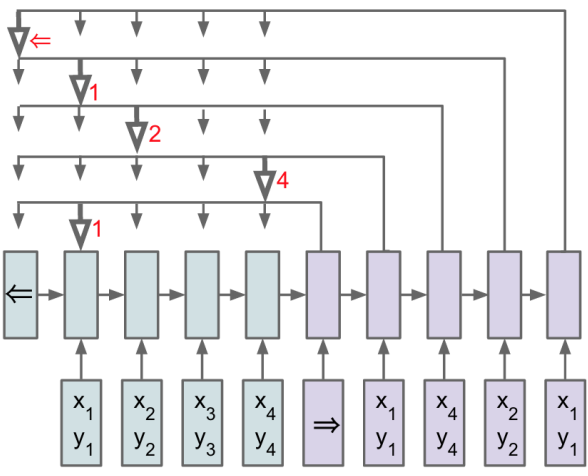



    ┏ --- 포인터
    |       ↑
    V        |
 인코더 => 디코더

In [1]:
# import module
import tensorflow as tf

import numpy as np
import os
import io
import time


#Define Token
START_ID = 0 #시퀀스 시작 토큰 ID
PAD_ID = 1   #시퀀스 공백 토큰 ID
END_ID = 2   #시퀀스 종결 토큰 ID

#Parameter
#입력 최대 길이
ENC_MAX_STEP = 5
#Label 최대 길이
DATA_MAX_OUTPUT = ENC_MAX_STEP + 1

DATA_PATH = "./data/convex_hull_5_test.txt"
PREFIX = DATA_PATH[7:-4]
#Label + End Token 최대 길이 
DEC_MAX_STEP = DATA_MAX_OUTPUT + 1 #max output lengths

BATCH_SIZE = 256
EPOCHS = 100
UNITS = 256
LEARNING_RATE = 0.001
BEAM_WIDTH = 4
OUTPUT_STD = None
DROPOUT_RATE = 0.0
#graident Clipping 파라미터
CLIPPING_VALUE = None
TRAIN_DATA_RATIO = 0.9

In [2]:
#데이터 로드 및 배치 생성기 유틸리티

def load_Dataset(data_path, input_step, output_step):
    inputs = []
    inputs_masks = []
    inputs_lengths = []
    labels = []
    labels_masks = []
    labels_lengths = []
    ENC_MAX_STEP = input_step
    DEC_MAX_STEP = output_step
    with open(data_path, 'r') as file:
        line = file.readline()
        while line :
            one_input = np.zeros([ENC_MAX_STEP, 2], dtype=np.float32)
            one_input_mask = np.zeros([ENC_MAX_STEP], dtype=int)
            line = line.split()
            length = 0
            i = 0
            while(line[i] != 'output'):
                one_input[length][0] = float(line[i])
                one_input[length][1] = float(line[i + 1])
                one_input_mask[length] = 1
                i += 2
                length += 1
            inputs.append(one_input)
            inputs_masks.append(one_input_mask)
            inputs_lengths.append(length)
            i += 1
            one_label = np.ones([DEC_MAX_STEP], dtype = int) * -1
            one_label_mask = np.zeros([DEC_MAX_STEP], dtype = int)
            length = 0
            while (i < len(line)):
                # 0 = start_id, 1 = pad_id, 2 = end_id
                one_label[length] = int(line[i])
                one_label_mask[length] = 1
                length += 1
                i += 1
            one_label[length] = 0  #end token
            one_label_mask[length] = 1
            length += 1

            labels.append(one_label)
            labels_masks.append(one_label_mask)
            labels_lengths.append(length)
            line = file.readline()

    inputs = np.stack(inputs)
    inputs_masks = np.stack(inputs_masks)
    inputs_lengths = np.array(inputs_lengths)
    labels = np.stack(labels)
    labels_masks = np.stack(labels_masks)
    labels_lengths = np.array(labels_lengths)

    return inputs, labels
    

class Batcher:
    def __init__(self, x, y, randomize = False):
        self.test_x = x
        self.test_y = y
        self.test_random_idx = None
        self.test_random = randomize
    
    def get_batch(self, batch_size):
        def shuffle_idx(x):
            if (self.test_random):
                np.random.shuffle(x)
        
        if (self.test_random_idx is None):
            self.test_random_idx = np.arange(self.test_x.shape[0])
            shuffle_idx(self.test_random_idx)
        inp = []
        targ = []
        while (batch_size > self.test_random_idx.shape[0]):
            inp.append(self.test_x[self.test_random_idx])
            targ.append(self.test_y[self.test_random_idx])
            batch_size -= self.test_random_idx.shape[0]
            self.test_random_idx = np.arange(self.test_x.shape[0])
            shuffle_idx(self.test_random_idx)
        inp.append(self.test_x[self.test_random_idx[:batch_size]])
        targ.append(self.test_y[self.test_random_idx[:batch_size]])
        if (self.test_random_idx.shape[0] - batch_size == 0):
            self.test_random_idx = np.arange(self.test_x.shape[0])
            shuffle_idx(self.test_random_idx)
        else :
            self.test_random_idx = self.test_random_idx[batch_size:]
        inp = np.concatenate(inp, axis = 0)
        targ = np.concatenate(targ, axis = 0)
        return inp, targ
    def reset_random(self):
        self.test_random_idx = None
        

In [3]:
inputs, labels = load_Dataset(DATA_PATH, ENC_MAX_STEP, DEC_MAX_STEP)

print("예제 1번 점 집합")
print(inputs[:1])

print("예제 1번 정답")
print(labels[:1])



cut = int(inputs.shape[0] * TRAIN_DATA_RATIO)

train_inputs = inputs[:cut]
train_labels = labels[:cut]

val_inputs   = inputs[cut:]
val_labels   = labels[cut:]

train_batcher = Batcher(train_inputs, train_labels, randomize=True)
val_batcher   = Batcher(val_inputs, val_labels, randomize = False)

#if TEST_STEP == None:
#    TEST_STEP = max([val_inputs.shape[0] // BATCH_SIZE, 1])


STEPS_PER_EPOCH = cut//BATCH_SIZE

예제 1번 점 집합
[[[0.99624294 0.928026  ]
  [0.24557766 0.80411434]
  [0.43667576 0.3330164 ]
  [0.36675233 0.7146409 ]
  [0.8069548  0.14914954]]]
예제 1번 정답
[[ 1  2  3  5  1  0 -1]]


# Encoder and Decoder (+ Attention)



### 인코더와 디코더는 기본적으로 LSTM 모델을 사용한다.

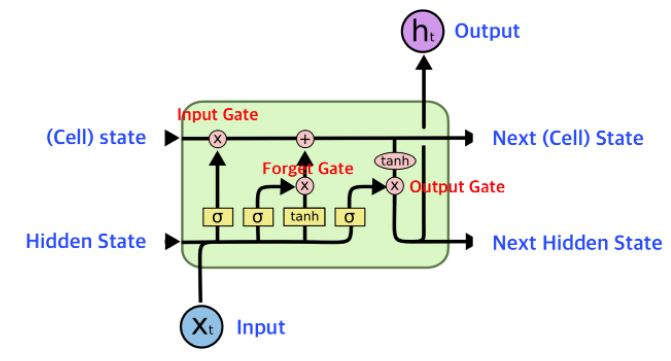

LSTM은 h와 c 두 개의 은닉 상태를 가진다.
* h: 단기 기억(이자 출력)
* c: 장기 기억


In [4]:
class Encoder(tf.keras.Model):
    def __init__(self, enc_units, batch_sz):
        #매개변수 설명
        #enc_unit: RNN의 뉴런 개수
        #          LSTM을 사용하기 때문에 h, c 
        #          즉 2*enc_unit 개의 파라미터를 가지게 된다.
        #batch_sz: 배치 크기 디폴트값
        #          최초 Zero 상태 출력할 때 사용
        
        #부모 클래스(tf.keras.Model) 초기화 호출
        super(Encoder, self).__init__()
        #객체 변수 할당
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        
        #RNN으로는 LSTM 사용 선언
        self.rnn = tf.keras.layers.RNN(
            tf.keras.layers.LSTMCell(self.enc_units, activation = 'tanh'),
            return_sequences = True, 
            return_state = True)
    
    #객체를 함수처럼 호출하면 실제로 실행되는 메소드
    # output, state = encoder(x, hidden)
    def call(self, x, hidden):
        #x :     [batch_size, time_step, n_features]
        #hidden: rnn cell에 대응되는 state 차원
        
        #output: [batch_size, times_step, enc_unit]
        # state는 마지막 time step의 Encoder의 상태
        # LSTM을 사용한다면, state는 [h, c] 두 벡터 원소를 
        # 가진 리스트로 출력된다
        #h:      [batch_size, enc_unit]
        #c:      [batch_size, enc_unit]
        output, *state = self.rnn(x, initial_state = hidden)
        return output, state

    #인코더의 최초 상태(zero state)를 반환하는 메소드
    #LSTM을 사용하기 때문에, 원소 두개의 리스트를 반환함
    def initialize_hidden_state(self, batch_size = None):
        #return zero state
        if (batch_size == None):
            return [tf.zeros((self.batch_sz, self.enc_units)), tf.zeros((self.batch_sz, self.enc_units))]
        else:
            return [tf.zeros((batch_size, self.enc_units)), tf.zeros((batch_size, self.enc_units))]

#BahdanauAttention을 변형한 Pointer layer
class Pointer(tf.keras.layers.Layer):
    def __init__(self, units, return_as_logits = True):
        # unit: Dense 계층의 뉴런 개수
        # return_as_logits: 마지막 pointer의 출력을
        #           소프트맥스를 통과한 확률(False)로 할 것인가
        #           스코어 값(True)으로 할 것인가.
        super(Pointer, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        self.return_as_logits = return_as_logits

    def call(self, query, keys):
        #query: (BATCH_SIZE, TIMESTEP, hidden_size) ((BATCH_SIZE, 1, hidden_size) at inference )
        #keys: (BATCH_SIZE, TABLESIZE, hidden_size), Table => End token + Encoder step
        
        time_step_length = query.shape[1]
        
         
        # enc_vec: (BATCH_SIZE, TABLESIZE, units)
        enc_vec = self.W1(keys)
        
        # enc_vec_with_time_axis: (BATCH_SIZE, TIMESTEP, TABLESIZE, units)
        enc_vec_with_time_axis = tf.tile(tf.expand_dims(enc_vec, 1), [1, time_step_length, 1, 1])
        
        #dec_vec: (BATCH_SIZE, TIMESTEP, units)
        dec_vec = self.W2(query)
        
        #dec_vec_for_broadcasting: (BATCH_SIZE, TIMESTEP, 1. units)
        dec_vec_for_broadcasting = tf.expand_dims(dec_vec, 2)
        
        
        #score: (BATCH_SIZE, TIMESTEP, TABLESIZE, 1)
        score = self.V(tf.nn.tanh(
            enc_vec_with_time_axis + dec_vec_for_broadcasting))
        
        
        if self.return_as_logits:
            return score
        
        # as Probablity
        # attention_weights: (BATCH_SIZE, TIMESTEP, TABLESIZE, 1)
        attention_weights = tf.nn.softmax(score, axis=2)

        return attention_weights

      
class Decoder(tf.keras.Model):
    def __init__(self, dec_units, batch_sz, return_as_logits = True):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.rnn = tf.keras.layers.RNN(
            tf.keras.layers.LSTMCell(self.dec_units, activation = 'tanh'),
            return_sequences = True, 
            return_state = True)

        # used for attention
        self.pointer = Pointer(self.dec_units, return_as_logits = return_as_logits)

    def call(self, x, hidden, values):
        #values: (batch_size, TABLESIZE, hidden_size)
        
        #output: (batch_size, dec_max_step, hidden_size )
        output, *state = self.rnn(x, initial_state = hidden)
        
        #score: (BATCH_SIZE, DEC_MAX_STEP, 1+ ENC_MAX_STEP, 1)
        score = self.pointer(output, values)

        return score, state
      
      
    

# Encoder-Decoder 결합한 전체 ptr-net

## self.end_token_outputs에 대하여

```python
if (output_std is None):
    # 0.0185 == output's std when unit = 256
    output_std = 0.0185 * np.sqrt(256 / unit)
self.end_token_outputs = tf.Variable(np.random.normal(0, output_std, [1, 1, unit]), dtype = np.float32)
```


Decoder의 Pointer는 매 스텝마다 인코더에 어떤 입력을 가리키는 방식과 같은 방식으로\
이 생성되고 있는 시퀀스가 "지금 끝났다" 라고 말할 수 있어야 한다.

그래서 우리는 Pointer가 우리가 임의로 정한 하나의 Key 값을 가리키게 되면\
Decoder가 이 시퀀스는 끝났음을 지시했다고 설계하고 싶은데\
그 Key 값을 self.end_token_outputs로 선언한 것이다.

이 값은 임의의 표준편차를 주고 정규분포로 정규화한 학습 가능한 파라미터로 두었지만...\
zero vector로 처리하고 학습이 불가능하게 하는 둥, 처리하는 방법은 다양한 듯 하다


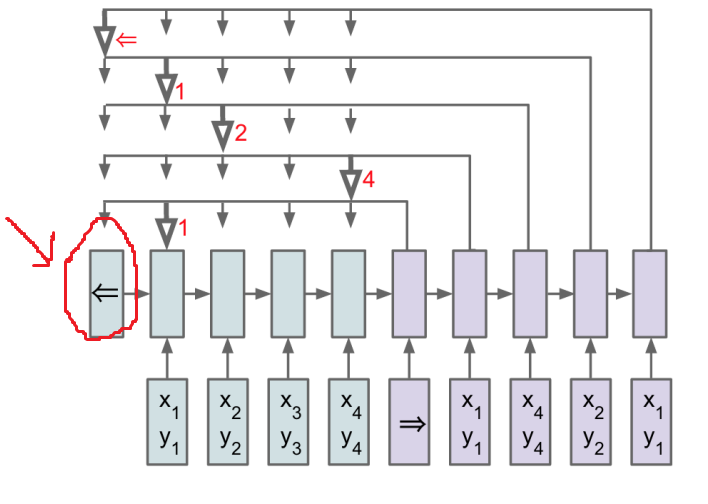

위 그림의 빨간 화살표가 End token의 Key vector를 나타낸 것이다.

In [5]:
class PointerNetwork:
    def __init__(self, unit, batch_size,
                 learning_rate = 0.001,
                 output_std = None,
                 dropout_rate = 0.0):
        self.encoder = Encoder(unit, batch_size)
        self.decoder = Decoder(unit, batch_size, return_as_logits = True)
        #Loss Function에 사용할 함수로 Cross Entropy 사용
        self.loss_object = tf.keras.losses.CategoricalCrossentropy(
                                      from_logits=True, reduction='none') 
        #학습 Optimizer 설정. Adam 사용
        self.optimizer = tf.keras.optimizers.Adam(learning_rate)
        #End token의 Key token 생성
        #make end token embedding for pointing
        if (output_std is None):
            # 0.0185 == output's std when unit = 256
            output_std = 0.0185 * np.sqrt(256 / unit)
        self.end_token_outputs = tf.Variable(np.random.normal(0, output_std, [1, 1, unit]), dtype = np.float32)
        
        #token 좌표 테이블
        #디코더의 매 스텝마다 출력이 나오면, 해당 출력에 해당하는 점의 좌표 값이 
        #다음 스텝으로 입력으로 들어가게 되는데
        #시작 토큰(0)이나 다른 토큰(1, 2)들이 나왔을 때, 다음 입력으로 들어갈 (x, y) 좌표 테이블이다.
        #임의로 설정 가능하며, (0 , 0)으로 설정함
        #token_table = [[begin_token, end_token, pad_token]]
        #begin_token = end_token = pad_token = (0, 0)
        self.token_table = tf.Variable(np.zeros([1, 3, 2]), dtype = np.float32)
        
        self.dropout_rate = dropout_rate
        
        #Checkpoint 파라미터 전달용 dict
        self.model = {}
        self.model['encoder'] = self.encoder
        self.model['decoder'] = self.decoder
        self.model['optimizer'] = self.optimizer
        self.model['end_token_outputs'] = self.end_token_outputs
        
    def get_model(self):
        return self.model
    
    #정답 real(정수값)와 스코어 pred(실수 점수)가 들어오면 두 값의 loss를 구함 
    def loss_function(self, real, pred):
        #real.shape = (BATCH_SIZE, DEC_MAX_STEP)
        #pred.shape = (BATCH_SIZE, DEC_MAX_STEP, 1 + ENC_MAX_STEP, 1)
        
        #real_onehot.shape = (BATCH_SIZE, DEC_MAX_STEP, 1 + ENC_MAX_STEP)
        real_onehot = tf.one_hot(real, pred.shape[-2], on_value = 1.0)
        
        #loss_ = (BATCH_SIZE, DEC_MAX_STEP)
        loss_ = self.loss_object(real_onehot, pred)
        
        #real(정답)에서 padding(-1)에 해당하는 부분은 제외함
        #mask = (BATCH_SIZE, DEC_MAX_STEP)
        mask = tf.math.logical_not(tf.math.equal(real, -1))
        
        mask = tf.cast(mask, dtype=loss_.dtype)
        loss_ *= mask
        return tf.reduce_sum(loss_) / tf.reduce_sum(mask) , loss_, mask
    
    #Teacher forcing
    #학습의 용이를 위하여 이전 스텝의 정답(targ[t-1])을 이번 스텝의 입력으로 넣는 학습법
    def teacher_forcing_run(self, inp, targ):
        #inp:  [BATCH_SIZE, ENC_MAX_STEP, 2]
        #targ: [BATCH_SIZE, DEC_MAX_STEP]
      
        #local batch size
        local_bsz = inp.shape[0]
        
        #zero state
        enc_state = self.encoder.initialize_hidden_state(local_bsz) 
        
        #Encoder 출력 파트 
        #enc_output.shape = (BATCH_SIZE, ENC_MAX_STEP, hidden_size)
        enc_output, enc_state = self.encoder(inp, enc_state)
        
        #Dropout
        if self.dropout_rate != 0.0:
            enc_output = tf.nn.dropout(enc_output, rate = self.dropout_rate)
            #LSTM 대응
            if type(enc_state) == list:
                for i in range(len(enc_state)):
                    enc_state[i] = tf.nn.dropout(enc_state[i], rate = self.dropout_rate)
            #LSTM이 아닌 GLU같은거
            else:
                enc_state = tf.nn.dropout(enc_state, rate = self.dropout_rate )
        
        #enc_output with end token output
        # .shape = (BATCH_SIZE, 1 + ENC_MAX_STEP, hidden_size )
        enc_output = tf.concat([tf.tile(self.end_token_outputs, [local_bsz, 1, 1]),
                            enc_output], 1)
        
        # token table에 대한 자세한 설명은 __init__ 함수 참고
        #tiled_token_table = (BATCH_SIZE, 3, 2)
        tiled_token_table = tf.tile(self.token_table, [local_bsz, 1, 1])
        #enc_table = (BATCH_SIZE, 3 + ENC_MAX_STEP, 2)
        #[token_table | input_table]
        enc_table = tf.concat([tiled_token_table, inp], 1)

        #시작 입력 (시작 토큰)
        #dec_input = (BATCH_SIZE, 1)
        dec_input = tf.expand_dims([START_ID] * local_bsz, 1)
        
        #teacher forcing 입력 설계
        #매 스텝의 입력은 다음과 같이 처리된다.
        #[start_token, first_label, ... last_label, pad_token, ...]
        
        #dec_input = (BATCH_SIZE, DEC_MAX_STEP), 정수형
        dec_input = tf.concat([dec_input, tf.cast(targ[:, :-1] + END_ID, dtype=np.int32)], 1)
        #dec_input = (BATCH_SIZE, DEC_MAX_STEP, 1)
        dec_input = tf.expand_dims(dec_input,-1)
        
        #dec_input = (BATCH_SIZE, DEC_MAX_STEP, 2)
        #좌표 테이블로 부터 id에 대응되는 (x, y) 좌표를 얻어낸다.
        dec_input = tf.gather_nd(enc_table, dec_input, batch_dims=1)
        #predictions = (BATCH_SIZE, DEC_MAX_STEP, 1 + ENC_MAX_STEP, 1)
        #encoder => enc_state => decoder
        #                         ^
        #                      x ┚
        predictions, dec_state = self.decoder(dec_input, enc_state, enc_output)
        
        total_loss, losses, masks = self.loss_function(targ, predictions) 
        return predictions, total_loss, losses, masks
    
    #without teacher forcing
    def naive_run(self, inp, targ,
                  return_as_idx = False,
                  max_length = 99999,
                  FORCED_TO_MAKE_TRIANGLE = False,
                  **kwargs): 
        #local batch size
        local_bsz = inp.shape[0]
        #zero state
        enc_state = self.encoder.initialize_hidden_state(local_bsz) 
        #enc_output.shape = (BATCH_SIZE, ENC_MAX_STEP, hidden_size)
        enc_output, enc_state = self.encoder(inp, enc_state)
        #enc_output with end token output
        # .shape = (BATCH_SIZE, 1 + ENC_MAX_STEP, hidden_size )
        enc_output = tf.concat([tf.tile(self.end_token_outputs, [local_bsz, 1, 1]),
                            enc_output], 1)
        
        # token table에 대한 자세한 설명은 __init__ 함수 참고
        #tiled_token_table = (BATCH_SIZE, 3, 2)
        tiled_token_table = tf.tile(self.token_table, [local_bsz, 1, 1])
        #enc_table = (BATCH_SIZE, 3 + ENC_MAX_STEP, 2)
        #[token_table | input_table]
        enc_table = tf.concat([tiled_token_table, inp], 1)

        #dec_input = (BATCH_SIZE, 1)
        dec_input = tf.expand_dims([START_ID] * local_bsz, 1)
        #encoder => state = > decoder
        dec_state = enc_state
        predictions = []
        predictions_idx = []
        losses = []
        total_loss = 0
        masks = []
        
        for t in range(0, min(targ.shape[1], max_length) ):
            #id - > (x, y)
            #dec_input = (BATCH_SIZE, 2)
            dec_input = tf.gather_nd(enc_table, dec_input, batch_dims=1)
            #dec_input = (BATCH_SIZE, time_axis = 1, 2)
            dec_input = tf.expand_dims(dec_input, 1)
            #predictions = (BATCH_SIZE, 1, 1 + ENC_MAX_STEP, 1)
            prediction, dec_state = self.decoder(dec_input, dec_state, enc_output)
            
            #loss = (BATCH_SIZE, 1)
            #mask = (BATCH_SIZE, 1)
            loss_sum, loss, mask = self.loss_function(targ[:, t:t+1], prediction)
            total_loss += loss_sum
            losses.append(loss)
            masks.append(mask)
            #predicted_idx.shape = (BATCH_SIZE, 1, 1)
            predicted_idx = tf.argmax(prediction, axis = 2)
            dec_input = predicted_idx[:, :, 0] + END_ID
            predictions_idx.append(predicted_idx)
            predictions.append(prediction)
            
        predictions = tf.concat(predictions, 1)
        predictions_idx = tf.concat(predictions_idx, 1)
        losses = tf.concat(losses, 1)
        masks = tf.concat(masks, 1)
        if return_as_idx:
            return predictions_idx, total_loss, losses, masks
        else:
            return predictions, total_loss, losses, masks
   
    
    #학습 함수
    @tf.function
    def step(self, inp, targ, clipping_value = None):
        #inp.shape == (BATCH_SIZE, ENC_MAX_STEP , input_size = 2 (x,y) )
        #targ.shape == (BATCH_SIZE, DEC_MAX_STEP)
        assert (inp.shape[0] == targ.shape[0])
        loss = 0
        #local batch size
        local_bsz = inp.shape[0];
        
        with tf.GradientTape() as tape:
            predictions, loss, each_loss, mask = self.teacher_forcing_run(inp, targ)
        variables = self.encoder.trainable_variables + self.decoder.trainable_variables + [self.end_token_outputs]
        gradients = tape.gradient(loss, variables)
        if (clipping_value is not None):
            gradients, _ = tf.clip_by_global_norm(gradients, clipping_value)
        self.optimizer.apply_gradients(zip(gradients, variables))
        
        return loss
    
    #평가하기
    def eval(self, inp, targ,
             **kwargs
            ):
        #inp.shape == (BATCH_SIZE, ENC_MAX_STEP , input_size = 2 (x,y) )
        #targ.shape == (BATCH_SIZE, DEC_MAX_STEP)
        assert (inp.shape[0] == targ.shape[0])
        loss = 0
        #local batch size
        local_bsz = inp.shape[0];
        #predictions.shape = (BATCH_SIZE, DEC_MAX_STEP, 1)
        #mask = (BATCH_SIZE, DEC_MAX_STEP)
        predictions, loss, each_loss, mask = self.naive_run(inp, targ,
                                                            return_as_idx=True)
       

        
        
        #correct_without_mask = (BATCH_SIZE, DEC_MAX_STEP)
        correct_without_mask = tf.cast(tf.equal(predictions[:, :, 0], targ), dtype=np.float32)
        step_hit = tf.reduce_sum(tf.math.multiply(correct_without_mask, mask) )
        total_step = tf.reduce_sum(mask)
        step_acc = np.array([step_hit.numpy(), total_step.numpy()], dtype = np.int32)
        
        all_step_correct = 0
        is_each_step_correct= correct_without_mask + (1.0 - mask)
        
        for i in range(local_bsz):
            if (tf.reduce_sum(is_each_step_correct[i]) >= is_each_step_correct.shape[1]):
                all_step_correct += 1;
        
        acc = all_step_correct / local_bsz
        
        ret = [predictions, acc]
        return ret

# Pointer Network 및 체크포인트 선언, 학습된 값 복원, 실험 코드

In [6]:
#Test Code
PN = PointerNetwork(UNITS, BATCH_SIZE,
                    learning_rate = LEARNING_RATE,
                    output_std = OUTPUT_STD,
                    dropout_rate=DROPOUT_RATE)

checkpoint_dir = "./training_checkpoints/pn" + PREFIX
checkpoint_prefix = os.path.join(checkpoint_dir, "pn")
checkpoint = tf.train.Checkpoint(**PN.get_model())

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

(predictions, acc) =  PN.eval(inputs[:1], labels[:1])

print("예측 id: ")
for i in range( predictions.shape[1]):
    print(predictions[0,i,0].numpy(), "", end="")
print()
print("정답 id: ")
for i in range( labels.shape[1]):
    print(labels[0,i], "", end="")

예측 id: 
0 0 0 0 0 0 0 
정답 id: 
1 2 3 5 1 0 -1 

# 검증 코드

In [7]:
def validation_print(N = 10):
    val_batcher.reset_random()
    acc = 0.0
    for _ in range(N):
        inp, lab = val_batcher.get_batch(BATCH_SIZE)
        result, tmp_acc = PN.eval(inp, lab)
        acc += tmp_acc

    acc = acc / N
    
    print("Evaluation: ")
    print("acc: ", acc)
    
    for i in range(min(5, BATCH_SIZE) ):
        print("=====================sample {0}=====================".format(i + 1))
        r_str = "result: ["
        t_str = "target: ["
        for j in range(result.shape[1]):
            r_str += "{:^3}".format(result[i, j, 0])
        for j in range(DEC_MAX_STEP):
            t_str += "{:^3}".format(lab[i, j])
        r_str += "]"
        t_str += "]"
        print(r_str)
        print(t_str)
    print("----------------------------------")
    return acc

In [8]:
validation_print()

Evaluation: 
acc:  0.0
=====================sample 1=====================
result: [ 0  0  0  0  0  0  0 ]
target: [ 1  3  5  2  4  1  0 ]
=====================sample 2=====================
result: [ 0  0  0  0  0  0  0 ]
target: [ 1  3  2  5  1  0 -1 ]
=====================sample 3=====================
result: [ 0  0  0  0  0  0  0 ]
target: [ 1  4  3  2  5  1  0 ]
=====================sample 4=====================
result: [ 0  0  0  0  0  0  0 ]
target: [ 1  5  3  2  4  1  0 ]
=====================sample 5=====================
result: [ 0  0  0  0  0  0  0 ]
target: [ 1  4  2  1  0 -1 -1 ]
----------------------------------


0.0

In [9]:
#학습하기
for epoch in range(EPOCHS):
    start = time.time()


    total_loss = 0

    for batch in range(STEPS_PER_EPOCH):
        inp, targ = train_batcher.get_batch(BATCH_SIZE)

        batch_loss = PN.step(inp, targ, clipping_value = CLIPPING_VALUE)
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))
        #if batch % 1000 == 0:
        #    validation_print()

    # saving (checkpoint) the model every 2 epochs
    checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                        total_loss / STEPS_PER_EPOCH))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    

Epoch 1 Batch 0 Loss 1.7899
Epoch 1 Loss 1.7481
Time taken for 1 epoch 2.677159309387207 sec

Epoch 2 Batch 0 Loss 1.6107
Epoch 2 Loss 1.3728
Time taken for 1 epoch 0.8975412845611572 sec

Epoch 3 Batch 0 Loss 1.2057
Epoch 3 Loss 1.1203
Time taken for 1 epoch 0.9110426902770996 sec

Epoch 4 Batch 0 Loss 1.0801
Epoch 4 Loss 1.0795
Time taken for 1 epoch 0.9393744468688965 sec

Epoch 5 Batch 0 Loss 1.0769
Epoch 5 Loss 1.0677
Time taken for 1 epoch 0.8537898063659668 sec

Epoch 6 Batch 0 Loss 1.0817
Epoch 6 Loss 1.0622
Time taken for 1 epoch 0.8256440162658691 sec

Epoch 7 Batch 0 Loss 1.0651
Epoch 7 Loss 1.0575
Time taken for 1 epoch 0.8409359455108643 sec

Epoch 8 Batch 0 Loss 1.0450
Epoch 8 Loss 1.0545
Time taken for 1 epoch 0.8617069721221924 sec

Epoch 9 Batch 0 Loss 1.0695
Epoch 9 Loss 1.0572
Time taken for 1 epoch 0.911651611328125 sec

Epoch 10 Batch 0 Loss 1.0444
Epoch 10 Loss 1.0533
Time taken for 1 epoch 0.9100620746612549 sec

Epoch 11 Batch 0 Loss 1.0617
Epoch 11 Loss 1.0528


Epoch 86 Loss 0.0833
Time taken for 1 epoch 0.9461345672607422 sec

Epoch 87 Batch 0 Loss 0.0809
Epoch 87 Loss 0.0901
Time taken for 1 epoch 0.9402551651000977 sec

Epoch 88 Batch 0 Loss 0.0954
Epoch 88 Loss 0.0839
Time taken for 1 epoch 0.9711916446685791 sec

Epoch 89 Batch 0 Loss 0.1008
Epoch 89 Loss 0.0809
Time taken for 1 epoch 0.9728801250457764 sec

Epoch 90 Batch 0 Loss 0.0796
Epoch 90 Loss 0.0796
Time taken for 1 epoch 0.8424439430236816 sec

Epoch 91 Batch 0 Loss 0.0771
Epoch 91 Loss 0.0802
Time taken for 1 epoch 0.8114707469940186 sec

Epoch 92 Batch 0 Loss 0.0865
Epoch 92 Loss 0.0829
Time taken for 1 epoch 0.8220329284667969 sec

Epoch 93 Batch 0 Loss 0.0663
Epoch 93 Loss 0.0768
Time taken for 1 epoch 0.8624377250671387 sec

Epoch 94 Batch 0 Loss 0.0733
Epoch 94 Loss 0.0751
Time taken for 1 epoch 0.9075243473052979 sec

Epoch 95 Batch 0 Loss 0.0798
Epoch 95 Loss 0.0762
Time taken for 1 epoch 0.9240367412567139 sec

Epoch 96 Batch 0 Loss 0.0779
Epoch 96 Loss 0.0756
Time take

In [10]:
#검증
validation_print()

Evaluation: 
acc:  0.79765625
=====================sample 1=====================
result: [ 1  3  5  2  4  1  0 ]
target: [ 1  3  5  2  4  1  0 ]
=====================sample 2=====================
result: [ 1  3  2  5  1  0  0 ]
target: [ 1  3  2  5  1  0 -1 ]
=====================sample 3=====================
result: [ 1  4  3  2  5  1  0 ]
target: [ 1  4  3  2  5  1  0 ]
=====================sample 4=====================
result: [ 1  5  3  2  4  1  0 ]
target: [ 1  5  3  2  4  1  0 ]
=====================sample 5=====================
result: [ 1  4  2  1  0  0  0 ]
target: [ 1  4  2  1  0 -1 -1 ]
----------------------------------


0.79765625

# Convex hull 그리기

In [11]:
import matplotlib.pyplot as plt

def plot_convex_hull(inp, targ, pred):

  fig = plt.figure(figsize=[12, 6])

  ax = plt.subplot(1, 2, 1)

  plt.scatter(inp[:, 0], inp[:, 1])

  for mx in range(0, targ.shape[0]):
    if targ[mx] == 0:
      break;

  plt.plot(inp[targ[:mx]-1, 0], inp[targ[:mx]-1, 1])

  plt.gca().invert_yaxis()
  plt.axis("off")

  plt.title("Label")

  ax = plt.subplot(1, 2, 2)

  plt.scatter(inp[:, 0], inp[:, 1])

  for mx in range(0, pred.shape[0]):
    if pred[mx] <= 0:
      break;

  plt.plot(inp[pred[:mx]-1, 0], inp[pred[ :mx]-1, 1])

  plt.gca().invert_yaxis()
  plt.axis("off")

  plt.title("Prediction")


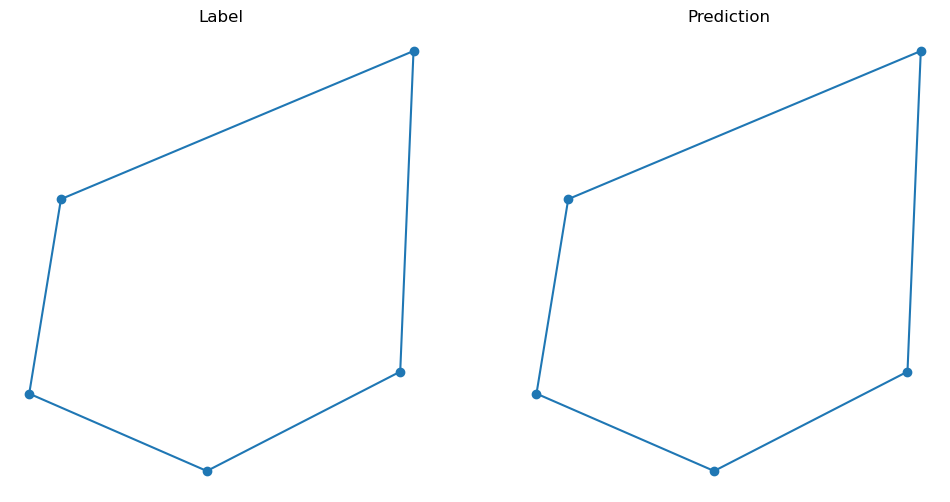

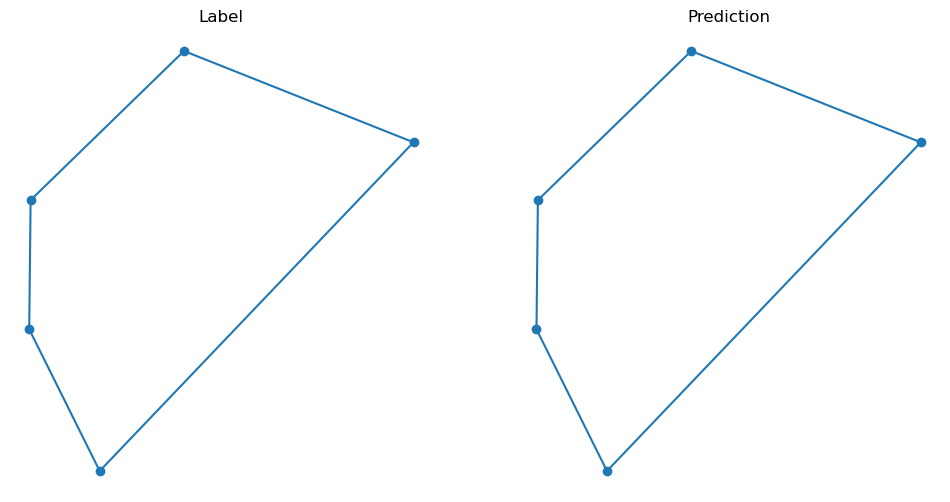

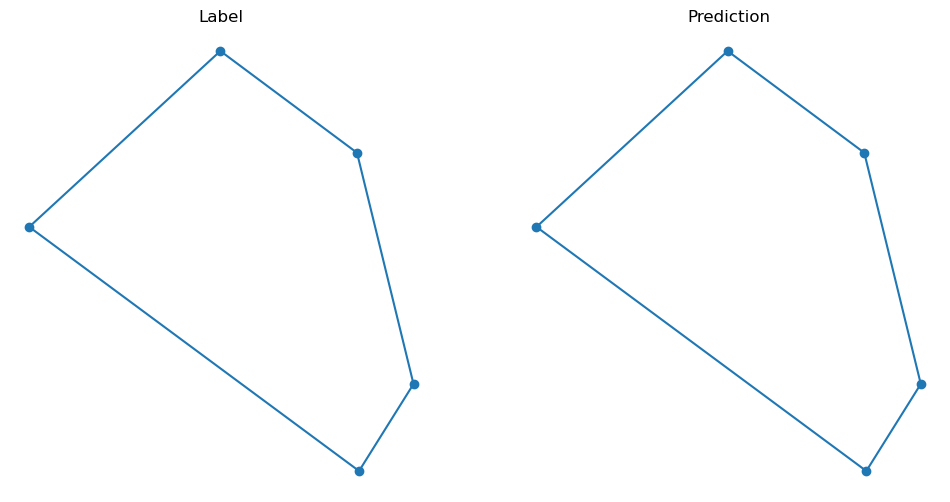

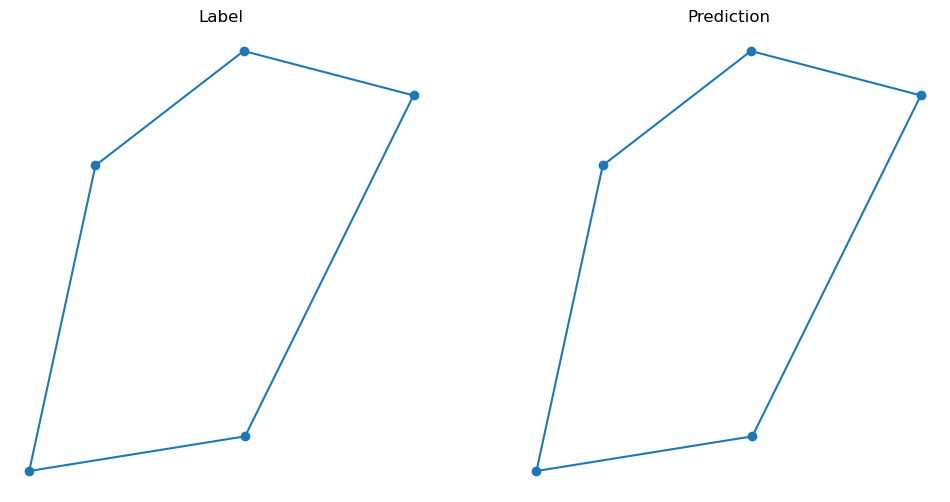

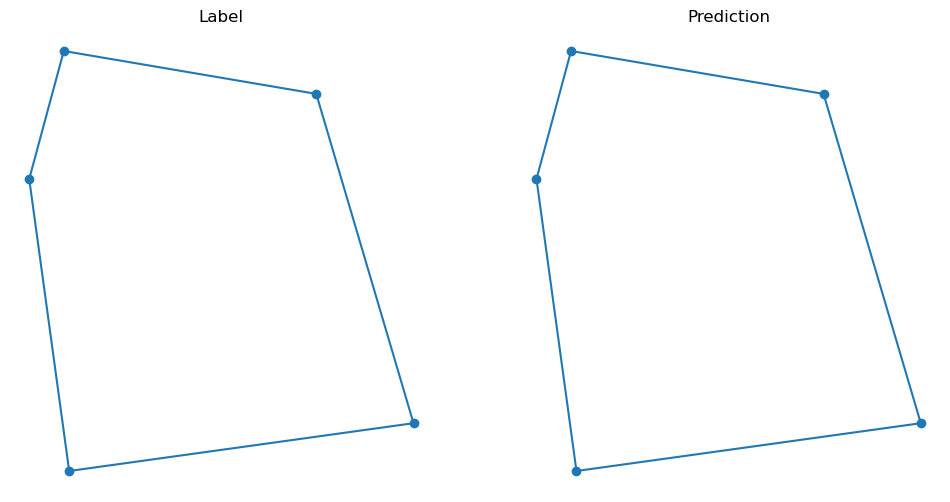

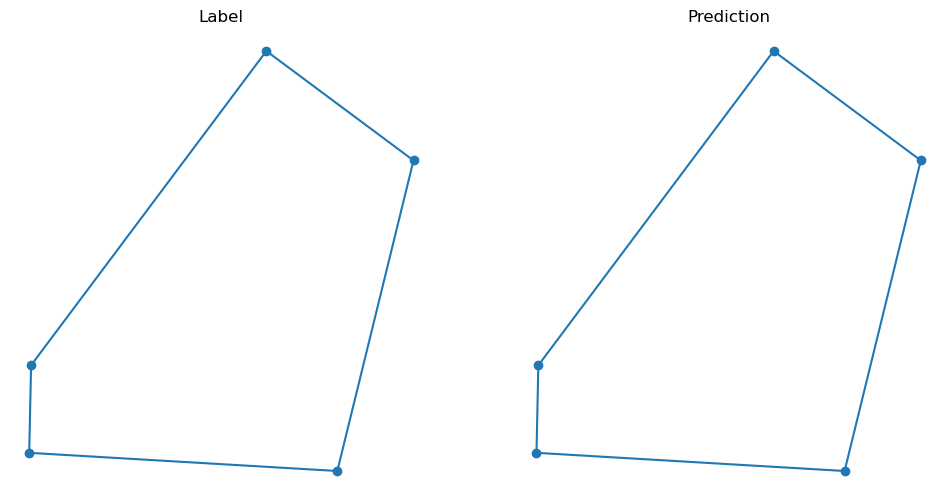

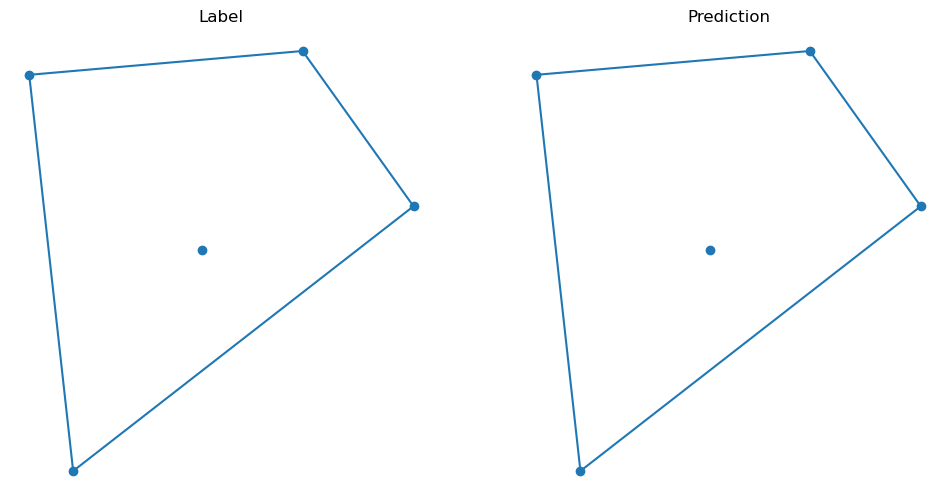

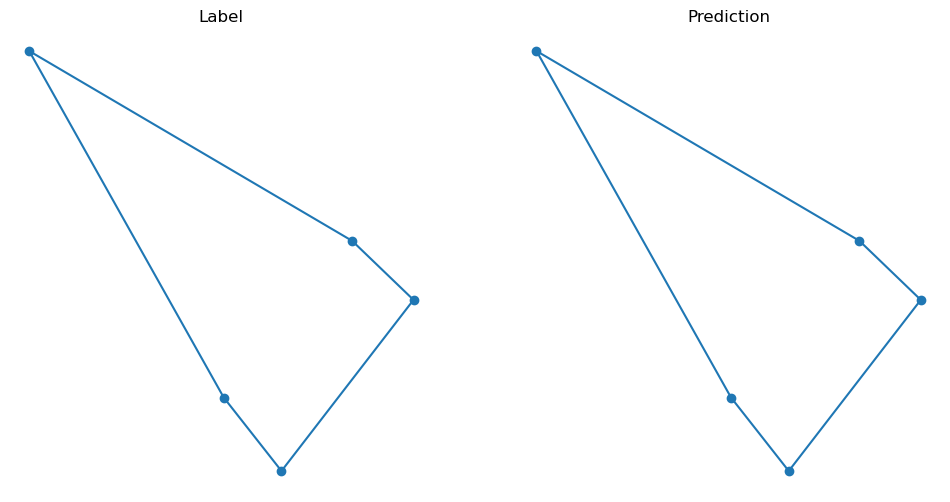

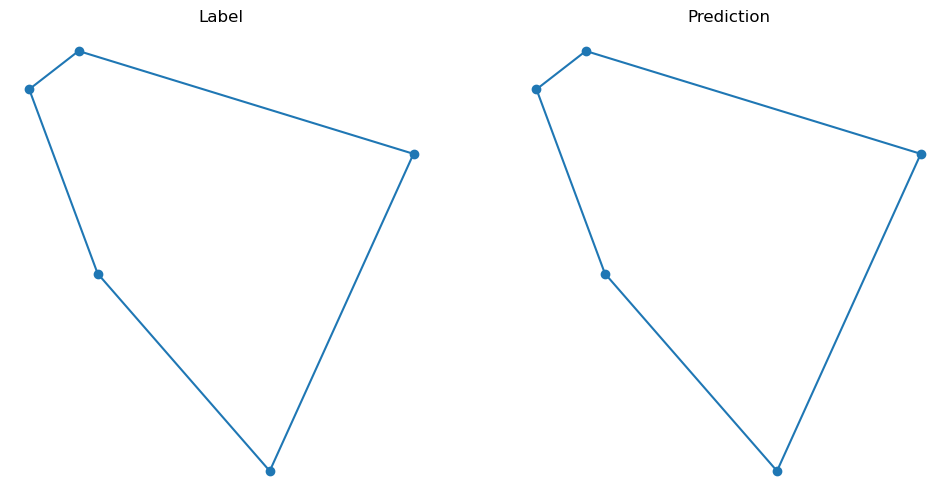

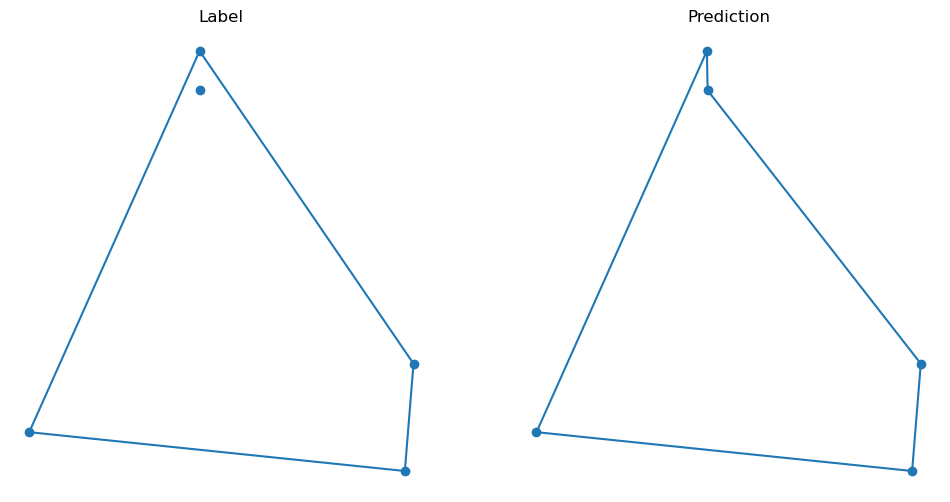

In [12]:
#draw convex hull

n_samples = 10

predictions, _ = PN.eval(val_inputs[:n_samples], val_labels[:n_samples])

for i in range(n_samples):
  plot_convex_hull(val_inputs[i], val_labels[i], predictions[i])